# CS4487 - Course Project: Aerial Cactus Identification

## Motivation
Increasing deforestation and wildfires have affected the flora and fauna in ecologically sensitive regions, leading to global warming and extinction of the rich ecosystem within these sensitive regions. The VIGIA project, led by a group of researchers in Mexico, aims to assist the goverment in its efforts to preserve the protected regions within the country.
Traditional surveillance system have proven to be insufficient due to labour intensive nature of manual logging and the lack of innovations. Thus, new technology that allow automatic surveillence through the use of unmanned drones can be used to take images of the protected area landscape, with computer vision recognition system assisting in  distinguish the flora/fauna and logging the number of protected species, etc.
In this project, our group has undertaken the task of building a computer vision recognition system that detects a certain species of columnar cactus in
protected areas, from images compiled the VIGIA Project. [1]


## Goal
The goal of this project is to predict whether an image captured from an umanned drone contains the columnar cactus species. In Machine Learning, this problem is a typical case of a binary classification, where the developed model predicts if the image has the columnar cactus species or not, using the features present in the image.


## Methodology
*You need to train classifiers using the training data, and then predict on the test data. You are free to choose the feature extraction method and classifier algorithm.  You are free to use methods that were not introduced in class.  You should probably do cross-validation to select a good parameters.*


## Evaluation on Kaggle

You need to submit your test predictions to Kaggle for evaluation.  50% of the test data will be used to show your ranking on the live leaderboard.  After the assignment deadline, the remaining 50% will be used to calculate your final ranking. 

To submit to Kaggle you need to create an account, and use the competition invitation that will be posted on Canvas.

**Note:** You can only submit 2 times per day to Kaggle!



## Kaggle Notebooks

You can use Kaggle notebooks to run your code. This ipynb has also been uploaded to the Kaggle competition site. 

# Load the Data

The class labels `"1"` for images containing cactus and `"0"` for others.

To submit to Kaggle, you need to generate a Kaggle submission files, which is CSV file with the following format. `'id'` is the file name of the input image: 

<pre>
Id,Prediction
cactus_0181_18.jpg,1
Sinplanta.4365.jpg,0
...
</pre>

Here are two helpful functions for reading the data and writing the Kaggle submission file.

In [1]:
%matplotlib inline
import IPython.core.display         
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
import seaborn as sn
from glob import glob
from scipy import stats
import csv
import os
import sklearn
from sklearn.metrics import confusion_matrix
import numpy as np 
import pandas as pd 
import fnmatch
import time
import random
random.seed(100)
from datetime import datetime
from tqdm.notebook import tqdm

# OpenCV Image Library
import cv2
from PIL import Image as pilimg


# Unzip/Create dataset folders
import shutil
import zipfile

# Import PyTorch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import *
import torch.optim as optim

torch.set_printoptions(linewidth=120)  

In [2]:
#### IF USING KAGGLE TO RUN

print(os.listdir('../input/cs4487-2020fall/'))
def read_train_data():
    cactus_imgs = glob("../input/cs4487-2020fall/training_set/training_set/cactus/*")
    cactus_labels = ones(len(cactus_imgs), dtype=int)
    nocactus_imgs = glob("../input/cs4487-2020fall/training_set/training_set/no_cactus/*")
    nocactus_labels = zeros(len(nocactus_imgs), dtype=int)

    train_X = cactus_imgs + nocactus_imgs
    train_Y = hstack((cactus_labels, nocactus_labels))
    return train_X, train_Y

def read_test_data():
    return glob("../input/cs4487-2020fall/validation_set/validation_set/*/*")

rootDir = "../input/cs4487-2020fall/"
### CHECK AND PRINT STATEMENTS FOR READ DATA
train_X, train_Y = read_train_data()
print(train_X[0], train_Y[0])
print(train_X[15000], train_Y[15000])
print(len(train_X))

test_X = read_test_data()
print(test_X[0])
print(len(test_X))
print(os.path.basename(test_X[0]))

trainingPath = 'training_set/'
validationPath = 'validation_set/'

['validation_set.csv', 'validation_set', 'training_set.csv', 'training_set']
../input/cs4487/training_set/training_set/cactus/cactus_0144_226.jpg 1
../input/cs4487/training_set/training_set/no_cactus/Sinplanta.1152.jpg 0
17500
../input/cs4487/validation_set/validation_set/no_cactus/Sinplanta.4502.jpg
4000
Sinplanta.4502.jpg


In [ ]:
# IF USING ON LOCAL MACHINE

def read_train_data():
    cactus_imgs = glob("training_set/cactus/*")
    cactus_labels = ones(len(cactus_imgs), dtype=int)
    nocactus_imgs = glob("training_set/no_cactus/*")
    nocactus_labels = zeros(len(nocactus_imgs), dtype=int)

    train_X = cactus_imgs + nocactus_imgs
    train_Y = hstack((cactus_labels, nocactus_labels))
    return train_X, train_Y

def read_test_data():
    return glob("validation_set/*/*")

### CHECK AND PRINT STATEMENTS FOR READ DATA
train_X, train_Y = read_train_data()
print(train_X[0], train_Y[0])
print(train_X[15000], train_Y[15000])
print(len(train_X))

test_X = read_test_data()
print(test_X[0])
print(len(test_X))
print(os.path.basename(test_X[0]))

trainingPath = 'training_set/'
validationPath = 'validation_set/'

In [3]:
def write_csv_kaggle_sub(fname, X, Y):
    # fname = file name
    # X is a list with image names
    # Y is a list/array with class entries
    
    # header
    tmp = [['Id', 'Prediction']]
    
    # add ID numbers for each Y
    for x,y in zip(X, Y):
        tmp2 = [x, y]
        tmp.append(tmp2)
        
    # write CSV file
    with open(fname, 'w') as f:
        writer = csv.writer(f)
        writer.writerows(tmp)

# Contents

- Data Extraction, Preporcessing, and Understanding.
- Utility Functions
- Basic Model
- Improved Vanilla CNN Model
- Densenet191(Transfer Learning) Model - **For testing purposes use this model**

# DATA EXTRACTION, PREPROCESSING, AND UNDERSTANDING

**Understanding the Problem**:
- What data do we have?: Structured
- What are we trying to predict? - Discrete/Niminal Prediction
- What kind of task is it?: Classification and Supervised


As we can see below we have two sets of images:

- **Training and Validation set**: 17500 images - We divide training and validation by a split of *99.9/0.01* after trying multipl options like *80.0/20.0*. We will expand further in the split section.  
- **Test set**: 4000 images

**Data Preprocessing and Feature Engineering**
Can an algorithm interpret our data?

- Prepare data
- Convert to PIL image for manipulation
- Data Augmentation
    - Resizing
    - Random Flips
    - Random Cropping
    - Random Rotation
    - Normalizing
    - Color Jitters
- Visualizing Data
- Visualizing the Image Channels

**Three Different Types of Models**

- Lenet5CNN

- Customized CNN

- Transfer learning using Densenet


In [4]:
# write csv files to upload to dataset - change paths if not using on kaggle
with open ('training_set.csv','w') as f:
    writer = csv.writer(f)
    for i in range(len(train_Y)):
        fname = os.path.basename(train_X[i])
        writer.writerow([ fname,train_Y[i], train_X[i]])

cactus_imgs = glob("../input/cs4487-2020fall/validation_set/validation_set/cactus/*")
cactus_labels = ones(len(cactus_imgs), dtype=int)
nocactus_imgs = glob("../input/cs4487-2020fall/validation_set/validation_set/no_cactus/*")
nocactus_labels = zeros(len(nocactus_imgs), dtype=int)

test_Y = hstack((cactus_labels, nocactus_labels))

with open ('validation_set.csv','w') as f:
    writer = csv.writer(f)
    for i in range(len(test_Y)):
        fname = os.path.basename(test_X[i])
        writer.writerow([fname,test_Y[i], test_X[i]])



In [5]:
# Our own custom class for datasets
class CactiDataset(Dataset):
    def __init__(self, data, dataDirectory = './', transform=None):
        super().__init__()
        self.DF = data.values
        self.data_dir = data.imagePath
        self.transform = transform

    def __len__(self):
        return len(self.DF)
    
    def __getitem__(self, index):
        img_name, label, imagePath = self.DF[index]
        image = cv2.imread(imagePath)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [6]:
## Turn CSVs into a Panda Dataframe

#hasCactus == 1 indicates that the image is a cactus, hasCactus == 0 indicate that the image is not a cactus
head = ['fileName','hasCactus', 'imagePath']
trainDF = pd.read_csv("training_set.csv", names = head, header = None)
testDF = pd.read_csv("validation_set.csv", names = head, header = None)

trainDF.head()

,fileName,hasCactus,imagePath
0,cactus_0144_226.jpg,1,../input/cs4487/training_set/training_set/cact...
1,cactus_0153_188.jpg,1,../input/cs4487/training_set/training_set/cact...
2,cactus_0070_510.jpg,1,../input/cs4487/training_set/training_set/cact...
3,cactus_0115_36.jpg,1,../input/cs4487/training_set/training_set/cact...
4,cactus_0083_37.jpg,1,../input/cs4487/training_set/training_set/cact...


In [9]:
print("Training Size: {}".format(len(glob('../input/cs4487-2020fall/training_set/training_set/*/*.jpg'))))
print("Validation Size: {}".format(len(glob('../input/cs4487-2020fall/validation_set/validation_set/*/*.jpg'))))

Training Size: 17500
Validation Size: 4000


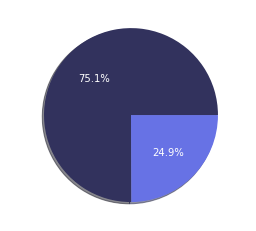

<Figure size 864x864 with 0 Axes>

In [10]:
# Counting the number of sample data for each class

%matplotlib inline
dataCount = trainDF.hasCactus.value_counts()

plt.pie(dataCount, labels=['Has Cactus', 'No Cactus'], autopct='%1.1f%%', colors=['#32325d', '#6772e5'], textprops={'color': 'white'}, shadow=True) #e6ebf1, #87bbfd
plt.figure(figsize=(12,12))
plt.show()

### Visualization of RGB Channels

The cactus images have three dimensions for their RGB values and all these three color dimensions are used in CNN model to extract features hence we will visualize and plot the color channels here to have a better view of the cactus images. 

To get a better idea about how these three color channels represent information and how they vary in their channel value distribution we also look at the normalized RGB color channels as three separate grayscale intensity images.

Each little square in the  second visualization represents pixels with normalized values. Hence, larger values indicate a brighter pixel and smaller values indicate a dark pixel. 


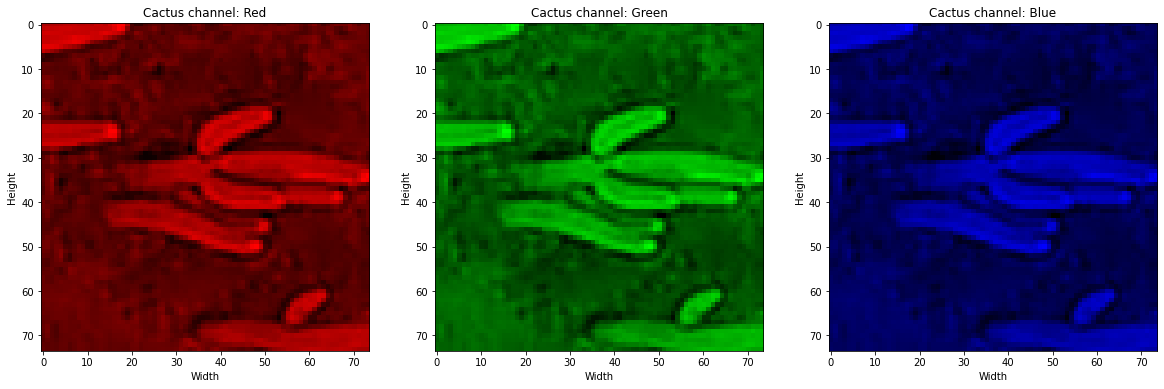

In [11]:
from PIL import Image as pilimg

# Select a random Image from the training set and then read that image in PIL format, then extract RGB channels individually and plot them. 
cactiDF = trainDF[trainDF.hasCactus==1].sample(n=1)
sourceImage = pilimg.open(cactiDF.iloc[0, 2])
sourceCactusImage = np.array(sourceImage)

# plt.imshow(y, cmap = plt.get_cmap('gray'))
fig = plt.figure(1, figsize=(20, 20))
channels = ['Red', 'Green', 'Blue']
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    # create empty image with same shape as that of the source image
    extractedImage = np.zeros(sourceCactusImage.shape, dtype='uint8')
    #assign the ith channel of the source to the empty image - hence i = 0 is Red , 1 is Green and 2 is Blue
    extractedImage[:,:,i] = sourceCactusImage[:,:,i]
    ax.imshow(extractedImage)
    plt.ylabel('Height'.format(sourceCactusImage.shape[0]))
    plt.xlabel('Width'.format(sourceCactusImage.shape[1]))
    plt.title("Cactus channel: " + channels[i])
plt.show()

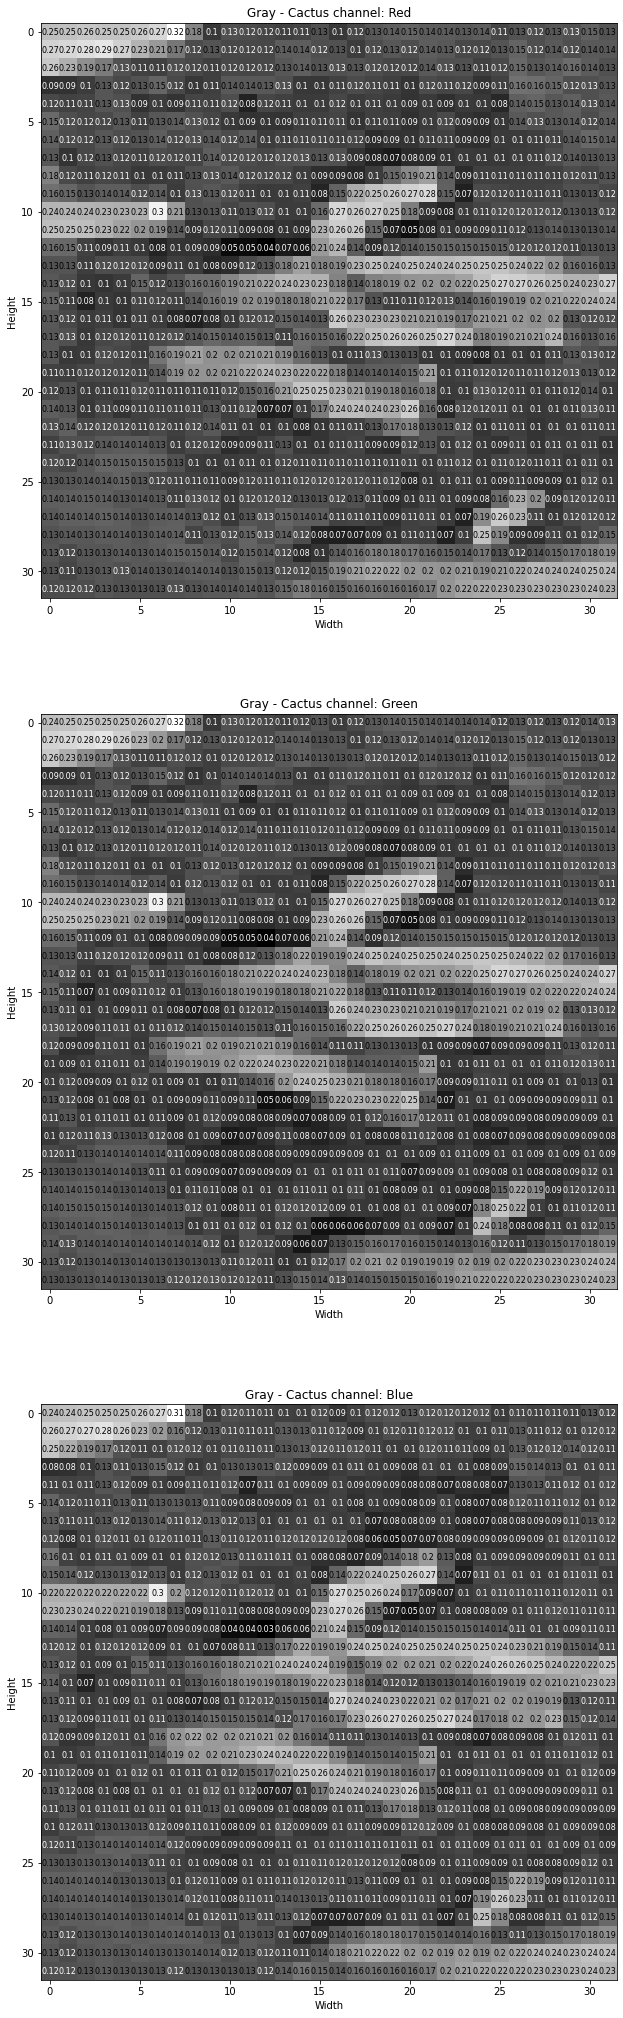

In [12]:
### TO HAVE A CLEAR UNDERSTANDING AND DISPLAY OF THE INTENSITY OF PIXEL VALUES WE RESIZE THE IMAGES TO 32 x 32 

sourceCactusImage = np.array(sourceImage.resize((32, 32)))

fig = plt.figure(1, figsize=(36, 36))
for i in range(3):
    ax = fig.add_subplot(3, 1, i+1)
    # create empty image with same shape as that of the source image
    extractedImage = np.zeros(sourceCactusImage.shape, dtype='uint8')
    #assign the ith channel of the source to the empty image - hence i = 0 is Red , 1 is Green and 2 is Blue
    extractedImage[:,:,i] = sourceCactusImage[:,:,i]
    extractedGrayImage =  extractedImage / 255
    extractedGrayImage = np.mean(extractedGrayImage, axis=2)
    ax.imshow(extractedGrayImage, cmap="gray")
    width, height = extractedGrayImage.shape
    threshold = extractedGrayImage.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(extractedGrayImage[x][y],2) if extractedGrayImage[x][y] !=0 else 0
            ax.annotate(str(val), xy = (y, x),
                    horizontalalignment='center',
                    verticalalignment='center', 
                    size=8,
                    color='white' if extractedGrayImage[x][y] < threshold else 'black')
    plt.ylabel('Height'.format(extractedGrayImage.shape[0]))
    plt.xlabel('Width'.format(extractedGrayImage.shape[1]))
    plt.title("Gray - Cactus channel: " + channels[i])
plt.show()

By looking at the above figures, we can make an assumption on how the CNN works. The CNN identifies the structure of the cactus through the different intensities of the red, green and blue channels, and its geometric position on the image. It is these values that the kernel uses to detect the presence of cactus in the image, and thus classifies it as present or not.

# Utility Functions to Set up dataset and training in Pytorch

In [13]:
# Data paths
trainingPath = 'training_set/'
validationPath = 'validation_set/'

In [14]:
# check for CUDA
TRAIN_CUDA = torch.cuda.is_available()

if not TRAIN_CUDA:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [15]:
# Our own custom class for datasets
class CactiDataset(Dataset):
    def __init__(self, data, dataDirectory = './', transform=None):
        super().__init__()
        self.DF = data.values
        self.data_dir = data.imagePath
        self.transform = transform

    def __len__(self):
        return len(self.DF)
    
    def __getitem__(self, index):
        img_name, label, imagePath = self.DF[index]
        image = cv2.imread(imagePath)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [16]:
def splitTrainingData(trainData, batchSize=32, validationSize=0.2):

    # obtain training indices that will be used for validation
    num_train = len(trainData)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(validationSize * num_train))
    train_index, valid_index = indices[split:], indices[:split]

    # Create Samplers
    train_sampler = SubsetRandomSampler(train_index)
    valid_sampler = SubsetRandomSampler(valid_index)

    # prepare data loaders (combine dataset and sampler)
    trainLoader = DataLoader(trainData, batch_size=batchSize, sampler=train_sampler)
    validLoader = DataLoader(trainData, batch_size=batchSize, sampler=valid_sampler)
    return trainLoader, validLoader

In [17]:
classes = [ 'No Cactus','Has Cactus']

In [18]:
def plotUnormalizedImages(train_loader):
    # obtain one batch of training images
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(20, 5))
    # display 10 unnormalized images
    for index in np.arange(10):
        ax = fig.add_subplot(2, 10/2, index+1, xticks=[], yticks=[])
#         unnormalize
        img = images[index] / 2 + 0.5   
        # convert from Tensor image and display
        plt.imshow(np.transpose(img, (1, 2, 0)))
        ax.set_title(classes[labels[index]])

In [19]:
def trainAndValidateModel(model, lossFunction, optimizer, epochs, trainLoader, validLoader, scheduler, isScheduler=False):
    
    '''
    This utility function is used to train and validate models
    It takes as input model, lossFunction, optimizer, 
    the number of epochs, trainLoader, validLoader, scheduler, and the boolean isScheduler which is by default False. Because we
    aren't using scheduler in one of the models
    
    '''
    print("Training Started...")
    
    # We use this to track changes in the validation loss -  so that the best model can be used later for eval. 
    valid_loss_min = np.Inf 

    # History of training and validation losses for each epoch
    trainingLoss = []
    validationLoss = []
    trainingAccuracy = []
    validationAccuracy = []

    for epoch in range(0, epochs):
        epochStartTime = time.time()

        # variables to keep track of per epoch loss and accuracy
        trainLossEpoch = 0.0
        validLossEpoch = 0.0
        trainAccuracyEpoch = 0.0
        validAccuracyEpoch = 0.0
        accurateTrainPredictionsEpoch = 0.0
        accurateValidPredictionsEpoch = 0.0

        """Train the model here - like any other CNN model we just train the model here"""
        model.train()
        for data, labels in trainLoader:
             # move tensors to GPU if CUDA is available
            if TRAIN_CUDA:
                data, labels = data.cuda(), labels.cuda()
            # clear gradients of all the optimized variables
            optimizer.zero_grad()
            # forward pass - compute the predicted outputs by passing inputs to the model
            prediction = model(data)
            # Predicted class
            predictedClass = prediction.argmax(dim=1)
            # calculate the loss for the batch
            loss = lossFunction(prediction, labels)
            # backward pass
            loss.backward()
            # optimization step - parameter update
            optimizer.step()
            # update training loss and accuracy
            trainLossEpoch += loss.item()*data.size(0)
            accurateTrainPredictionsEpoch += predictedClass.eq(labels).sum().item()
            if isScheduler:
                scheduler.step()

    #     trainingAccuracy += trainAccuracyEpoch

        """Now we validate the model and check for validation accuracy"""

        model.eval()
        for data, labels in validLoader:
            if TRAIN_CUDA:
                data, labels = data.cuda(), labels.cuda()
            prediction = model(data)
            predictedClass = prediction.argmax(dim=1)
            loss = lossFunction(prediction, labels)
            # update average validation loss 
            validLossEpoch += loss.item()*data.size(0)
            accurateValidPredictionsEpoch += predictedClass.eq(labels).sum().item()

        # Calculate the accuracies for the epoch
        validAccuracyEpoch = accurateValidPredictionsEpoch / len(validLoader.sampler)
        trainAccuracyEpoch = accurateTrainPredictionsEpoch / len(trainLoader.sampler)
        validationAccuracy.append(validAccuracyEpoch)
        trainingAccuracy.append(trainAccuracyEpoch)

        # calculate average losses
        trainLossEpoch = trainLossEpoch /len(trainLoader.sampler)
        validLossEpoch = validLossEpoch /len(validLoader.sampler)
        trainingLoss.append(trainLossEpoch)
        validationLoss.append(validLossEpoch)

        hours, rem = divmod(time.time() - epochStartTime, 3600)
        minutes, seconds = divmod(rem, 60)
        epochTime = str(int(minutes)) + ":" + str(int(seconds))


        print('Epoch: {} - {} minutes \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
            epoch+1, epochTime, trainLossEpoch, validLossEpoch, validAccuracyEpoch*100))

        # save model if validation loss has decreased
        if validLossEpoch <= valid_loss_min:
            print('Validation loss decreased from {:.6f} to {:.6f} Saving the model for after evaluations'.format(
            valid_loss_min,
            validLossEpoch))
            torch.save(model.state_dict(), 'best_model.pt')
            valid_loss_min = validLossEpoch
    
    print("End Training...")
    return trainingLoss, validationLoss, trainingAccuracy, validationAccuracy

In [20]:
def plotLossCurves(trainingLoss, validationLoss):
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    plt.plot(trainingLoss, label='Training loss', color="#32325d")
    plt.plot(validationLoss, label='Validation loss', color='#6772e5')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(frameon=False)

In [21]:
def plotAccuracyCurves(trainingAccuracy, validationAccuracy):
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    plt.plot(trainingAccuracy, label='Training Accuracy', color="#32325d")
    plt.plot(validationAccuracy, label='Validation Accuracy', color='#6772e5')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

In [22]:
def getTrueAndPredictedLabels(model, loader):
    targetLabels = []
    modelPrediction = []

    for images, label in loader:
        if TRAIN_CUDA:
            images, label = images.cuda(), label.cuda()
        label = label.tolist()
        targetLabels.append(label)

        scores = model(images)
        _, predictions = scores.max(1)
        modelPrediction.append(predictions.tolist())

    predictedLabels = [item for sublist in modelPrediction for item in sublist]
    trueLabel = [item for sublist in targetLabels for item in sublist]
    return trueLabel, predictedLabels

In [23]:
def confusionMatrix(trueLabel, predictedLabels, dataType="Test"):
    confusionMatrix = confusion_matrix(trueLabel, predictedLabels)
    df_cm = pd.DataFrame(confusionMatrix, index = ['No cactus', 'Has cactus'],
    columns = ['No cactus', 'Has cactus'])
    df_cm.index.name = '{} Data - True Label'.format(dataType)
    df_cm.columns.name = '{} Data - Predicted label'.format(dataType)
    plt.figure(figsize=(8,8))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 20}, fmt = '2', cmap="PuBu") 
    plt.show()

In [24]:
def PlotROCCurve(trueLabel, predictedLabels, dataType="Test"):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(trueLabel, predictedLabels)
    auc = sklearn.metrics.auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label='ROC curve (auc = {:.6f} %)'.format(auc), color="#32325d")
    plt.fill_between(x=fpr, y1=tpr,facecolor='#6772e5', alpha=0.5 )
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()
    return auc  

In [25]:
def checkAccuracy(model, loader, dataType="Test"):
    trueLabel = []
    predictedLabels = []
    num_correct = 0
    num_samples = 0
    model.eval()
    
    for images, labels in loader:
        if TRAIN_CUDA:
            images, labels = images.cuda(), labels.cuda()
            
        scores = model(images)
        predictions = scores.argmax(dim=1)
        trueLabel.append(labels)
        predictedLabels.append(predictions)
        num_correct += (predictions).eq(labels).sum()
        num_samples += predictions.size(0)
    print("{} Accuracy:".format(dataType))
    print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 

# CNN - Paper

The custom LeNet-5 network used in the original paper is configured as follows. It receives as input a 3-channel 32 × 32 image. Then, 6 convolution filters with size 5 × 5 are applied with stride one. Next, a max pooling operation is performed, using a kernel of 2 × 2 and stride 2. Then, a new set of 16 convolution kernels with size 5 × 5 and stride one is applied. Again a max pooling operation is performed, using a kernel of 2 × 2 and stride 2. Next, the features are flattened to a one dimension vector of size 400. Later, the three fully connected layers are applied with 120, 84, and 2 nodes respectively. Until this point, the output of the CNN is a vector of real numbers called logits. Therefore, a LogSoftMaxfunction is applied to convert the logits into a normalized probability distribution.

The Loss Function used in the original paper is **Negative logarithmic likelihood loss function** and **Adam's Optimizer** with the hyperparameters as follows: **Learning rate 0.01, number of epochs 150, and batch size 2500**.

In [26]:
class LeNet5CNN(nn.Module):
    def __init__(self):
        super(LeNet5CNN, self).__init__()
        self.firstConvolutionLayer = nn.Conv2d(3, 6, 5, stride=1)
        # Max-pooling
        self.firstMaxPool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Convolution
        self.secondConvolutionLayer = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        # Max-pooling
        self.secondMaxPool = nn.MaxPool2d(kernel_size=2)
        # Fully connected layer
        self.firstFullyConncetedLayer = nn.Linear(16*5*5, 120)   
        self.secondFullyConncetedLayer = nn.Linear(120, 84)      
        self.thirdFullyConncetedLayer = nn.Linear(84, 2)
        
    def forward(self, x):
        x = self.firstMaxPool(F.relu(self.firstConvolutionLayer(x)))  
        x = self.secondMaxPool(F.relu(self.secondConvolutionLayer(x)))
        # Now Flatten to a one dimension vector of size 400 i.e 16*5*5 
        x = x.view(-1, 16*5*5)
        # FC-1, then perform ReLU non-linearity
        x = F.relu(self.firstFullyConncetedLayer(x))
        # FC-2, then perform ReLU non-linearity
        x = F.relu(self.secondFullyConncetedLayer(x))
        # FC-3
        x = self.thirdFullyConncetedLayer(x)
        logits = x
        # After the third Fully connected layer Until the output of the CNN is a vector of real numbers called logits. Therefore, a LogSoftMax function is applied
        # to convert the logits into a normalized probability distribution
        logSoftMax = nn.LogSoftmax(dim=1)
        probs = logSoftMax(logits) 
        return probs 

In [27]:
model = LeNet5CNN()
print(model)

LeNet5CNN(
  (firstConvolutionLayer): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (firstMaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (secondConvolutionLayer): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (secondMaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (firstFullyConncetedLayer): Linear(in_features=400, out_features=120, bias=True)
  (secondFullyConncetedLayer): Linear(in_features=120, out_features=84, bias=True)
  (thirdFullyConncetedLayer): Linear(in_features=84, out_features=2, bias=True)
)


In [28]:
# It's unclear from the original paper if the authors used a validation set or not hence this might results in different results
# since we are using validation set with a 0.2 split. 
batchSize = 2500
validationSize = 0.2

trainingTransforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testTransforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create Test Data Set and Test Loader for the Model
test_data = CactiDataset(data=testDF, dataDirectory=validationPath, transform=testTransforms)
testLoader = DataLoader(test_data, batch_size=batchSize, shuffle=False)
# Train Data and Train Loader for the model
train_data = CactiDataset(data=trainDF, dataDirectory=trainingPath, transform=trainingTransforms)
trainLoader, validLoader = splitTrainingData(train_data, batchSize, validationSize)

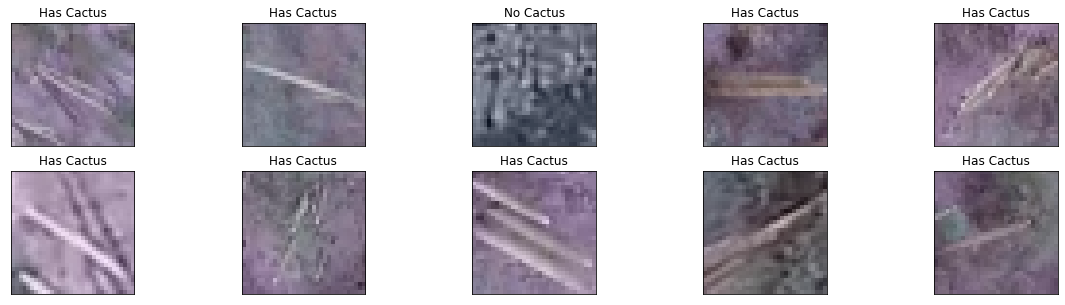

In [29]:
%matplotlib inline

# Visualize the unormalized images after transformations
plotUnormalizedImages(trainLoader)

### Train and Validate the model

In [ ]:
model = LeNet5CNN()
if TRAIN_CUDA:
    model.cuda()
lossFunction = nn.NLLLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.01)
epochs = 150

trainingLoss, validationLoss, trainingAccuracy, validationAccuracy = trainAndValidateModel(model, lossFunction, optimizer, epochs, trainLoader, validLoader, "scheduler", isScheduler=False)
# Load Best parameters learned from training into our model to make predictions later
model.load_state_dict(torch.load('best_model.pt'))

Training Started...
Epoch: 1 - 0:58 minutes 	Training Loss: 0.624545 	Validation Loss: 0.585350 	Validation Accuracy: 75.228571
Validation loss decreased from inf to 0.585350 Saving the model for after evaluations
Epoch: 2 - 0:31 minutes 	Training Loss: 0.535922 	Validation Loss: 0.525293 	Validation Accuracy: 75.228571
Validation loss decreased from 0.585350 to 0.525293 Saving the model for after evaluations
Epoch: 3 - 0:32 minutes 	Training Loss: 0.489684 	Validation Loss: 0.460205 	Validation Accuracy: 75.228571
Validation loss decreased from 0.525293 to 0.460205 Saving the model for after evaluations
Epoch: 4 - 0:33 minutes 	Training Loss: 0.429404 	Validation Loss: 0.392924 	Validation Accuracy: 75.228571
Validation loss decreased from 0.460205 to 0.392924 Saving the model for after evaluations
Epoch: 5 - 0:28 minutes 	Training Loss: 0.382409 	Validation Loss: 0.374406 	Validation Accuracy: 75.228571
Validation loss decreased from 0.392924 to 0.374406 Saving the model for after ev

Epoch: 49 - 0:26 minutes 	Training Loss: 0.058532 	Validation Loss: 0.052470 	Validation Accuracy: 98.057143
Epoch: 50 - 0:27 minutes 	Training Loss: 0.055891 	Validation Loss: 0.055121 	Validation Accuracy: 98.085714
Epoch: 51 - 0:27 minutes 	Training Loss: 0.050106 	Validation Loss: 0.051955 	Validation Accuracy: 98.085714
Epoch: 52 - 0:27 minutes 	Training Loss: 0.047134 	Validation Loss: 0.053370 	Validation Accuracy: 98.171429


In [ ]:
checkAccuracy(model, testLoader, dataType="Test")

In [ ]:
checkAccuracy(model, validLoader, dataType="Validation")

In [ ]:
checkAccuracy(model, trainLoader, dataType="Train")

### Visualize the results

In [ ]:
plotAccuracyCurves(trainingAccuracy, validationAccuracy)

In [ ]:
plotLossCurves(trainingLoss, validationLoss)

In [ ]:
trueLabel, predictedLabels = getTrueAndPredictedLabels(model, trainLoader)
confusionMatrix(trueLabel, predictedLabels,  dataType="Train")

In [ ]:
trueLabel, predictedLabels = getTrueAndPredictedLabels(model, testLoader)
confusionMatrix(trueLabel, predictedLabels,  dataType="Test")

In [ ]:
PlotROCCurve(trueLabel, predictedLabels)

# Improved Vanilla CNN

So after playing around for a while we applied an architecture such that we had a convolution layer which receives as input a 3-channel image and then, 6 convolution filters with size 3 × 3 are applied with stride one and padding one. Then, a new set of 32 filtered convolution kernels with size 3 × 3 , stride one and padding one is applied and then we have another set of same convolutional layers but with 64 filters followed by a last one which implements 128 filters.  On each layer of convolution, a max pooling operation is performed, using a kernel of 2 × 2 and stride two. Next, the features are flattened to a one dimension vector of size 400. Later, two fully connected layers are applied with 512 and 2 nodes respectively and then finally we also add a dropout layer with p=0.2.

The Loss Function used in the improved version is **CrossEntropy** we tried others like Binary Cross Entropy too but the results didn't improve much and **Adam's Optimizer** with the hyperparameters as follows: **Learning rate 0.001, number of epochs 30, and batch size 64**. The results improved but they could have been improved further using a more detailed analysis of where this model was going wrong. 


In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
         # define layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128*2*2, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.2)
     
    # define forward function
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 2 * 2)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        # don't need softmax here since we'll use cross-entropy as activation.
        return x

In [ ]:
model = ImprovedCNN()
print(model)

In [ ]:
batchSize = 64
validationSize = 0.2
trainingTransforms = transforms.Compose([transforms.ToPILImage(), 
                                         transforms.RandomHorizontalFlip(), 
                                            transforms.RandomVerticalFlip(),
                                            transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25),
                                            transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(1, 1.1)),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

testTransforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create Test Data Set and Test Loader for the Model
test_data = CactiDataset(data=testDF, dataDirectory=validationPath, transform=testTransforms)
testLoader = DataLoader(test_data, batch_size=batchSize, shuffle=False)
# Train Data and Train Loader for the model
train_data = CactiDataset(data=trainDF, dataDirectory=trainingPath, transform=trainingTransforms)
trainLoader, validLoader = splitTrainingData(train_data, batchSize, validationSize)

In [ ]:
%matplotlib inline
plotUnormalizedImages(trainLoader)

### Train and Validate the model

In [ ]:
model = ImprovedCNN()
if TRAIN_CUDA:
    model.cuda()
learningRate = 0.001
epochs = 30
lossFunction = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = learningRate/10, epochs=epochs, steps_per_epoch=len(trainLoader))

trainingLoss, validationLoss, trainingAccuracy, validationAccuracy = trainAndValidateModel(model, lossFunction, optimizer, epochs, trainLoader, validLoader, scheduler, isScheduler=True)
# Load Best parameters learned from training into our model to make predictions later
model.load_state_dict(torch.load('best_model.pt'))

In [ ]:
checkAccuracy(model, testLoader, dataType="Test")

In [ ]:
checkAccuracy(model, validLoader, dataType="Validation")

In [ ]:
checkAccuracy(model, trainLoader, dataType="Train")

### Visualize the results

In [ ]:
plotAccuracyCurves(trainingAccuracy, validationAccuracy)

In [ ]:
plotLossCurves(trainingLoss, validationLoss)

In [ ]:
trueLabel, predictedLabels = getTrueAndPredictedLabels(model, trainLoader)
confusionMatrix(trueLabel, predictedLabels,  dataType="Train")

In [ ]:
trueLabel, predictedLabels = getTrueAndPredictedLabels(model, testLoader)
confusionMatrix(trueLabel, predictedLabels,  dataType="Test")

In [ ]:
PlotROCCurve(trueLabel, predictedLabels)

# Densenet / Transfer learning Model - Model used for submission

Since multiple data ugmentation techniques along with different Learning rates and optimizers didn't yield us a ROC score of 1.00. We started with Pretrained Transfer Learning Models. We used noth ResNet and DenseNet because with our research these two models were the most famous and were expected to yield the best results. In the end fortunately Densenet gave us slightly better results then Resenet so we have included that here. 

**Dense Convolutional Network (DenseNet)**, connects each layer to every other layer in a feed-forward fashion. In comparison the traditional convolutional nets have N connections for N Layers - one between each layer and its subsequent layer. DenseNetsare known to solve the vanishing-gradient problem and have other improvememnts like substantial reduction of the number of parameters.

We also make use of Adaptive Pooling. For average-pooling or max-pooling we need to set the stride and kernel-size making them hyperparameters. 

In Adaptive Pooling we only specify the output size. And the stride and kernel-size are then  automatically adapted.

In [ ]:
class AdaptiveAvgPool(nn.Module): #for AdaptiveAvgPool2d and AdaptiveMaxPool2d
    def __init__(self, size=None):
        super().__init__()
        self.outputSize = size or 1
        self.a = nn.AdaptiveAvgPool2d(self.outputSize)
        self.m = nn.AdaptiveMaxPool2d(self.outputSize)

    def forward(self, x): 
        return torch.cat([self.m(x), self.a(x)], 1)
    
class Sequence(nn.Module):
    def __init__(self, inputFeatures): # inputFeatures defines the number of channels in the last convolutional layer
        super().__init__()
        self.avg = AdaptiveAvgPool()
        self.inputFeatures = inputFeatures
        self.layer1 = nn.Sequential(nn.BatchNorm1d(2*inputFeatures), nn.Dropout(0.25),
                                    nn.Linear(2*inputFeatures, 512), nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(nn.BatchNorm1d(512), nn.Dropout(0.5),
                                    nn.Linear(512, 2))
    
    def forward(self, x):
        out = self.avg(x)
        out = out.view(-1, self.inputFeatures*2)
        out = self.layer1(out)
        out = self.layer2(out)
        return out
    
class DensenetClf(nn.Module):
    def __init__(self, freeze=True):
        super().__init__()
        base_model = models.densenet161(pretrained=True)
        n_channels = base_model.classifier.in_features
        self.body = nn.Sequential(base_model.features, nn.ReLU(inplace=True))
        self.head = Sequence(n_channels)
        
        for x in self.body.parameters():
            x.requires_grad = False
        for x in self.body.modules():
            if isinstance(x, nn.modules.batchnorm._BatchNorm):
                x.bias.requires_grad = True
                x.weight.requires_grad = True
                x.reset_running_stats()
                
    
    def forward(self, x):
        out = self.body(x)
        return self.head(out)
    
    def predict(self, loader, device=torch.device('cpu')):
        pred_Y = torch.tensor([])
        with torch.no_grad():
            for batch in loader:
                image = batch[0].to(device)
                current_pred = self(image)
                pred_Y = torch.cat((pred_Y, current_pred.cpu().detach()))
        softmax = nn.Softmax(dim=1)
        pred_Y = softmax(y_pred)
        return pred_Y[:, 1].numpy()
    
    def unfreeze(self):
        for x in self.body.parameters():
            x.requires_grad = True


In [ ]:
batchSize = 32
validationSize = 0.01
trainingTransforms = transforms.Compose([transforms.ToPILImage(), 
                                transforms.Resize((128,128)),
                                transforms.RandomHorizontalFlip(), 
                                transforms.RandomVerticalFlip(),
                                transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25),
                                transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(1, 1.1)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

testTransforms = transforms.Compose([transforms.ToPILImage(), transforms.Resize((128,128)), transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


# Create Test Data Set and Test Loader for the Model
test_data = CactiDataset(data=testDF, dataDirectory=validationPath, transform=testTransforms)
testLoader = DataLoader(test_data, batch_size=batchSize, shuffle=False)
# Train Data and Train Loader for the model
train_data = CactiDataset(data=trainDF, dataDirectory=trainingPath, transform=trainingTransforms)
trainLoader, validLoader = splitTrainingData(train_data, batchSize, validationSize)

In [ ]:
#Hyperparameters
learnRate = 3e-2
epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
lossFunction = nn.CrossEntropyLoss(reduction='mean')
tensorboard = False


model = DensenetClf()
model.to(device)

global_step = 0

print(f'\nStart Training\n')
parameters = [{'params': model.body.parameters()},
              {'params': model.head.parameters()}]
optimizer = torch.optim.Adam(parameters, lr=learnRate)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=[learnRate/10, learnRate],
                                                epochs=epochs, steps_per_epoch=len(trainLoader))

for epoch in tqdm(range(epochs), desc='Epochs'):
    train_loss = 0.0
    validation_loss = 0.0
    start_time = datetime.now()
    #training step
    i = 0
    model.train()
    for image, label in tqdm(trainLoader, desc="Iteration"):
        image, label = image.to(device), label.to(device).squeeze()
        optimizer.zero_grad()
        predicted_label = model(image)
        loss = lossFunction(predicted_label, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        scheduler.step()
    
    #validate step
    model.eval()
    with torch.no_grad():
        for image, label in validLoader:
            image, label = image.to(device), label.to(device).squeeze()
            predicted_label = model(image)
            loss = lossFunction(predicted_label, label)
            validation_loss += loss.item()


    average_train_loss = train_loss/len(trainLoader)
    average_valid_loss = validation_loss/len(validLoader)
    delta = datetime.now()-start_time
    print(f"Epoch: {epoch}\tTrain Loss: {average_train_loss:.6f}\tVal Loss: {average_valid_loss:.6f}\t Time:{delta}")
    torch.save(model.state_dict(), f'model.pt')


print("End of Training")

In [ ]:
checkAccuracy(model, testLoader, dataType="Test")

In [ ]:
checkAccuracy(model, trainLoader, dataType="Training")

In [ ]:
checkAccuracy(model, validLoader, dataType="Validation")

In [ ]:
plotAccuracyCurves(trainingAccuracy, validationAccuracy)

In [ ]:
plotLossCurves(trainingLoss, validationLoss)

In [ ]:
trueLabel, predictedLabels = getTrueAndPredictedLabels(model, trainLoader)
confusionMatrix(trueLabel, predictedLabels,  dataType="Train")

In [ ]:
trueLabel, predictedLabels = getTrueAndPredictedLabels(model, testLoader)
confusionMatrix(trueLabel, predictedLabels,  dataType="Test")

In [ ]:
PlotROCCurve(trueLabel, predictedLabels)

## Submission

In [ ]:
test_prediction = []

model.eval()
for batch in testLoader:
    images = batch[0]  
    images = images.to(device)  
    scores = model(images)
    _, predictions = scores.max(1)
    test_prediction.append(predictions.tolist())

test_pred = [item for sublist in test_prediction for item in sublist]
test =  []
for file in test_X:
    fname = os.path.basename(file)
    test.append(fname)

write_csv_kaggle_sub('submission.csv', test, test_pred)

# Conclusion
 

In conclusion after using these three models where the original paper's model performed almost equal and sometimes worst than our improved model and the densenet model outperformed them all we were able to achieve higher accuracy scores with lower epochs each time from 150 epochs we brought it down to 10 epochs. However, we would have tried better ensembling methods and hyperparamter tuning methods like cyclic learning rates instead of relying on manual testing of hyperparameters like learning rate and batch sizes if we had better computational power and more time. The validation set size is important for hyperparameter tuning and to ensure that no overfitting occurs. The validation set needs to be a minimum of $1/(2n)^1/2$ of the dataset. Thus, in our case, the validation set needs to ~1%. We have also tried 20% and 10% and others using manual training, but again we would have tried better means to tune it and fine a better parameter rather than relying on the stanadard sizes used in various other models earlier. 


# Refrences 

- Efren López-Jiménez, Juan Irving Vasquez-Gomez, Miguel Angel Sanchez-Acevedo, Juan Carlos Herrera-Lozada, Abril Valeria Uriarte-Arcia, Columnar Cactus Recognition in Aerial Images using a Deep Learning Approach. Ecological Informatics. 2019.

- Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning (Adaptive computation and machine learning).

- https://jivg.org/research-projects/vigia/